# 3.1 가계금융조사 지니계수 계산

- [1 데이터](#1-데이터)
- [2 주요 통계 검토](#2-주요-통계-검토)
- [3 지니계수 검토](#3-지니계수-검토)
- [4 지니계수 추이](#3-지니계수-추이)

## 1 데이터

**가계금융복지조사**(Survey of Household Finances and Living Conditions) 
   - <a href="https://kostat.go.kr/board.es?mid=a10301040300&bid=215&act=view&list_no=422053">2022년 조사결과</a>, <a href="https://www.narastat.kr/metasvc/svc/SvcMetaDcDtaPopup.do?confmNo=930001">통계설명자료</a>, <a href="https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240">마이크로데이터</a>

미국은 SCF가 3년 주기로 행해지는데, 2022년 SCF의 경우, <a href="https://www.aeaweb.org/forum/1850/survey-consumer-finances-invites-comments-proposed-approach">2022년 4월부터 2023년 3월까지 본 조사(main survey)가 행해졌고</a>, 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 조사 시점을 기준으로 조사됐다. SCF 보고서는 모든 금액에 대해 CPI를 사용해 인플레이션 효과를 제거한 숫자를 사용해 분석하는 반면, (관측별 가중치를 제공하지만) 가중 평균 등은 사용하지 않는다.

한국은 가계금융복지조사가 매년 행해지는데, 2022년 조사의 경우, 2022년 4월에 본 조사가 행해졌고, 연간 소득 등의 변수는 2021년을 기준으로 조사됐고, 자산이나 부채 등은 2022년 3월말 시점을 기준으로 조사됐다. 가계금융복지조사 보고서는 CPI 등을 사용해 인플레이션 효과를 제거하지 않는 반면, 관측별 가중치를 사용해 가중 평균, 가중 중위값, 가중 지니계수 등을 산출하고 있다. 

본 분석에서는 모든 금액에 대해 관측별 가중치를 사용해 가중 평균, 가중 중위값, 가중 지니계수 등을 산출하기로 한다. 그리고 한국 통계당국은 소득 관련 분석의 경우, 가령 2022년 가계금융복지조사를 이용한 결과에 대해서는 (해당 소득 통계가 2021년을 기준으로 조사됐기 때문에) 2021년에 해당하는 결과로 보고하는데, 여기에서는 소득이나 자산 및 부채 구분하지 않고 이 경우 모두 2022년 결과로 표기하기로 한다.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt

#### 데이터 다운로딩

>원시(raw) 데이터는 <a href="https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240">MDIS</a>(MicroData Integrated Service)에서 "소득·소비·자산 > 가계금융조사"를 선택해 필요한 연도의 조사 자료를 다운로드 받는다. 
>
>다음 명령문은 다운로드 받은 2010년부터 2023년까지의 원시 CSV 파일을 불러들이는 작업이다. 

In [2]:
# 파일 경로와 이름의 패턴 설정
file_pattern = "../Data/SHF/{year}.csv"

# 데이터를 저장할 변수 초기화
dfs = []

# 2010부터 2023까지의 파일 로드
for year in range(2010, 2024):
    file_name = file_pattern.format(year=year)
    df_name = "df_{year}".format(year=year)
    df = pd.read_csv(file_name, encoding='EUC-KR')
    dfs.append((df_name, df))

# 결과를 변수에 저장
for df_name, df in dfs:
    globals()[df_name] = df

## 2 주요 통계 검토

- <a href="https://kostat.go.kr/boardDownload.es?bid=215&list_no=422053&seq=1">2022년 가계금융복지조사 결과</a>

### 평균값

![평균값](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-1.png)

- 위 표의 각주를 통해 데이터세트의 연도가 조사실시 연도이며, 자산‧부채‧순자산은 조사연도 3월말 기준, 소득‧지출은 전년 기준 자료라는 것을 알 수 있다.

In [3]:
x = df_2022['순자산']
weight = df_2022['가중값']
weight_sum = df_2022['가중값'].sum()
w = weight/weight_sum

In [4]:
# 2022년 순자산 단순평균 구하기
x.mean()

43034.836415283506

**weighted mean 함수**

In [5]:
def weighted_mean(x, w):
    # 가중 평균 계산
    weighted_sum = np.sum(x * w)
    total_weight = np.sum(w)
    mean = weighted_sum / total_weight
    return mean

In [6]:
weighted_mean(x, w), weighted_mean(x, weight)

(45602.32782013843, 45602.327820138424)

- **이를 통해 위 보도자료의 평균 금액은 단순평균이 아니라 가중평균 값이라는 것을 알 수 있다.**

### 중위값

![중위값](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-2.png)

In [7]:
# 순자산 중위값 I
x.median()

21660.0

**Weighted median**

- 출처: Wikipedia ([Weighted median](https://en.wikipedia.org/wiki/Weighted_median))

**가중 중위값**(weighted median)은 50% 가중 백분위수로, 1888년 F. Y. Edgeworth에 의해 처음 제안되었다.  
  
**정의 (일반적인 경우):**  $n$개의 서로 다른 정렬된 요소 $x_1, x_2, \ldots, x_n$와 양의 가중치 $w_1, w_2, \ldots, w_n$이 주어졌고, 이들이 $\sum_{i=1}^n w_i = 1$을 만족한다고 할 때, 가중 중위값은 다음 조건을 만족하는 요소 $x_k$이다.  
  
$$\sum_{i=1}^{k-1} w_i \leq 1/2 \ \text{그리고} \ \sum_{i=k+1}^{n} w_i \leq 1/2$$

In [8]:
def weighted_median(x, w):
    
    # 가중치 표준화
    w = w/w.sum()
    
    # 값과 가중치를 함께 정렬
    sorted_data = sorted(zip(x, w), key=lambda pair: pair[0])
    cumulative_weight = 0

    for value, weight in sorted_data:
        cumulative_weight += weight
        if cumulative_weight >= 0.5:
            return value

result = weighted_median(x, w)
print("가중 중위값:", result)
weighted_median(x, w), weighted_median(x, weight)

가중 중위값: 24662


(24662, 24662)

- **이를 통해 위 보도자료의 중위 금액은 단순 중위값이 아니라 가중 중위값이라는 것을 알 수 있다.**

### 백분위수

**The weighted percentile method**

출처: Wikipedia ([Percentile](https://en.wikipedia.org/wiki/Percentile#Weighted_percentile))


백분위수 함수 외에도, 총 개수 대신 총 가중치에서의 비율을 계산하는 가중 백분위수(weighted percentile)가 있다. 가중 백분위수에 대한 표준적인 함수는 없지만, 한 가지 방법은 백분위수 함수 접근법을 자연스럽게 확장하는 것이다.

정렬된 $N$개의 관측값에 각각 양의 가중치 $w_1, w_2, w_3, \dots, w_N$가 부여되어 있다고 하자. 가중치의 합은 다음과 같다.

$$S_N = \sum_{k=1}^N w_k.$$

위 공식을 다음과 같이 일반화할 수 있다.

$$ 
p_n = \frac{1}{S_N}\left(S_n - \frac{w_n}{2}\right)\ \text{($C=1/2$일 때)} 
$$

또는  

$$ 
p_n = \frac{S_n - Cw_n}{S_N +(1-2C)w_n}\ \text{(일반적인}\ C\text{의 경우)} 
$$

그리고  

$$
v = v_k + \frac{P - p_k}{p_{k + 1} - p_k}(v_{k + 1} - v_k).
$$

50% 가중 백분위수가 가중 중위값(weighted median)이다.

**weighted_percentile 함수**

In [9]:
def weighted_percentile(x, w, percentile):
    # x: 데이터 값의 리스트 또는 배열
    # w: 각 데이터 포인트의 가중치 리스트 또는 배열 (x와 크기가 같아야 함)
    # percentile: 계산할 백분위수 (0부터 100까지의 값)

    # 데이터와 가중치를 데이터와 가중치의 쌍으로 묶음
    data_with_weights = list(zip(x, w))

    # 데이터를 값에 따라 정렬
    data_with_weights.sort(key=lambda pair: pair[0])

    # 누적 가중치 초기화
    cumulative_weight = 0

    # 백분위수에 해당하는 가중치 임계값 계산
    target_weight = (percentile / 100) * sum(w)

    # 백분위수에 해당하는 데이터 값을 찾아 반환
    for value, weight in data_with_weights:
        cumulative_weight += weight
        if cumulative_weight >= target_weight:
            return value

    # 백분위수가 100인 경우 가장 큰 값을 반환
    return data_with_weights[-1][0]

weighted_percentile(x, w, 50), weighted_percentile(x, weight, 50)

(24662, 24662)

In [10]:
print("가중 0 백분위수:", weighted_percentile(x, weight, 0))
print("가중 10 백분위수:", weighted_percentile(x, weight, 10))
print("가중 20 백분위수:", weighted_percentile(x, weight, 20))
print("가중 30 백분위수:", weighted_percentile(x, weight, 30))
print("가중 40 백분위수:", weighted_percentile(x, weight, 40))
print("가중 50 백분위수:", weighted_percentile(x, weight, 50))
print("가중 60 백분위수:", weighted_percentile(x, weight, 60))
print("가중 70 백분위수:", weighted_percentile(x, weight, 70))
print("가중 80 백분위수:", weighted_percentile(x, weight, 80))
print("가중 90 백분위수:", weighted_percentile(x, weight, 90))
print("가중 100 백분위수:", weighted_percentile(x, weight, 100))

print("\n최소값:", min(x))
print("최대값:", max(x))

가중 0 백분위수: -77950
가중 10 백분위수: 1170
가중 20 백분위수: 5010
가중 30 백분위수: 10267
가중 40 백분위수: 16600
가중 50 백분위수: 24662
가중 60 백분위수: 34500
가중 70 백분위수: 49022
가중 80 백분위수: 70968
가중 90 백분위수: 108100
가중 100 백분위수: 1651550

최소값: -77950
최대값: 1651550


### 점유율

**weighted_sub_share 함수**

- 가중치를 사용하여 하위 그룹의 점유율을 구하는 함수

In [11]:
def weighted_sub_share(data, weight, lower, upper):
    
    # 전체 합계 계산
    total_sum = (data*weight).sum()
    
    # lower 백분위수와 upper 백분위수 계산
    p_lower = weighted_percentile(data, weight, lower)
    p_upper = weighted_percentile(data, weight, upper)
    
    # sub-group 값의 합계 계산
    sub_data = data[(data > p_lower) & (data <= p_upper)]
    sub_sum = (sub_data*weight).sum()
    
    # sub-group 값의 합계를 전체 합계로 나누기
    percentage = (sub_sum / total_sum) * 100
    
    return percentage

![점유율](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-3.png)

In [12]:
share_1 = weighted_sub_share(x, weight, 0, 10)
share_2 = weighted_sub_share(x, weight, 10, 20)
share_3 = weighted_sub_share(x, weight, 20, 30)
share_4 = weighted_sub_share(x, weight, 30, 40)
share_5 = weighted_sub_share(x, weight, 40, 50)
share_6 = weighted_sub_share(x, weight, 50, 60)
share_7 = weighted_sub_share(x, weight, 60, 70)
share_8 = weighted_sub_share(x, weight, 70, 80)
share_9 = weighted_sub_share(x, weight, 80, 90)
share_10 = weighted_sub_share(x, weight, 90, 100)

print("1분위 점유율:", round(share_1, 2))
print("2분위 점유율:", round(share_2, 2))
print("3분위 점유율:", round(share_3, 2))
print("4분위 점유율:", round(share_4, 2))
print("5분위 점유율:", round(share_5, 2))
print("6분위 점유율:", round(share_6, 2))
print("7분위 점유율:", round(share_7, 2))
print("8분위 점유율:", round(share_8, 2))
print("9분위 점유율:", round(share_9, 2))
print("10분위 점유율:", round(share_10, 2))

total = share_1+share_2+share_3+share_4+share_5+share_6+share_7+share_8+share_9+share_10
print("점유율 합계:", total)

1분위 점유율: -0.19
2분위 점유율: 0.64
3분위 점유율: 1.65
4분위 점유율: 2.93
5분위 점유율: 4.51
6분위 점유율: 6.44
7분위 점유율: 9.07
8분위 점유율: 12.91
9분위 점유율: 19.0
10분위 점유율: 43.03
점유율 합계: 100.00463780932658


### 소득 정의

![가구소득](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-4.png)

In [13]:
y1 = df_2022['경상소득(보완)']
y2 = df_2022['경상소득_근로소득(보완)']
y3 = df_2022['경상소득_사업소득(보완)']
y4 = df_2022['경상소득_재산소득(보완)']
y5 = df_2022['경상소득_공적이전소득(보완)']
y6 = df_2022['경상소득_사적이전소득(조사)']
y7 = df_2022['처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]']
weight = df_2022['가중값']

print('가구소득(y1):', round(weighted_mean(y1, weight)))
print('근로소득(y2):', round(weighted_mean(y2, weight)))
print('사업소득(y3):', round(weighted_mean(y3, weight)))
print('재산소득(y4):', round(weighted_mean(y4, weight)))
print('공적이전소득(y5):', round(weighted_mean(y5, weight)))
print('사적이전소득(y6):', round(weighted_mean(y6, weight)))
print('\n(경상소득-비소비지출)(y7):', round(weighted_mean(y7, weight)))
print('\n중위 가구소득:', weighted_median(y1, weight))

가구소득(y1): 6414
근로소득(y2): 4125
사업소득(y3): 1160
재산소득(y4): 426
공적이전소득(y5): 600
사적이전소득(y6): 103

(경상소득-비소비지출)(y7): 5229

중위 가구소득: 5022


![가구 비소비지출](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-5.png)

In [14]:
e1 = df_2022['지출_비소비지출(보완)']
e2 = df_2022['지출_비소비지출_세금(보완)']
e3 = df_2022['지출_비소비지출_공적연금사회보험료(보완)']
e4 = df_2022['지출_비소비지출_가구간이전지출(조사)']
e5 = df_2022['지출_비소비지출_비영리단체이전지출(조사)']
e6 = df_2022['지출_비소비지출_연간지급이자(조사)']

print('비소비지출(e1):', round(weighted_mean(e1, weight)))
print('비소비지출_세금(e2):', round(weighted_mean(e2, weight)))
print('공적연금사회보험료(e3):', round(weighted_mean(e3, weight)))
print('가구간이전지출(e4):', round(weighted_mean(e4, weight)))
print('비영리단체이전지출(e5):', round(weighted_mean(e5, weight)))
print('연간지급이자(e6):', round(weighted_mean(e6, weight)))

비소비지출(e1): 1185
비소비지출_세금(e2): 400
공적연금사회보험료(e3): 400
가구간이전지출(e4): 137
비영리단체이전지출(e5): 39
연간지급이자(e6): 209


#### 시장소득 & 처분가능소득

출처: <a href="https://www.narastat.kr/metasvc/svc/SvcMetaDcDtaPopup.do?confmNo=930001">통계설명자료</a>

>○ 시장소득 = 근로소득 $+$ 사업소득 $+$ 재산소득 $+$ (사적이전소득 $-$ 사적이전지출)  
>○ 처분가능소득 = 시장소득 $+$ 공적이전소득 $-$ 공적이전지출
>
>- 사적이전소득: 가구 간 또는 비영리단체로부터 받은 이전소득
>- 사적이전지출: 타 가구 또는 비영리단체에 지출하거나 기부한 금액
>- 공적이전소득: 공적연금(국민연금, 공무원연금, 사학연금, 별정우체국연금 등), 기초연금, 장애수당 등 정부의 사회수혜금
>- 공적이전지출: 소득세 등 직접세, 연금기여금 및 건강보험료 등 사회보험료 지출액

In [15]:
e1 = df_2022['지출_비소비지출(보완)']
e2 = df_2022['지출_비소비지출_세금(보완)']
e3 = df_2022['지출_비소비지출_공적연금사회보험료(보완)']
e4 = df_2022['지출_비소비지출_가구간이전지출(조사)']
e5 = df_2022['지출_비소비지출_비영리단체이전지출(조사)']
e6 = df_2022['지출_비소비지출_연간지급이자(조사)']

print('비소비지출(e1):', round(weighted_mean(e1, weight)))
print('비소비지출_세금(e2):', round(weighted_mean(e2, weight)))
print('공적연금사회보험료(e3):', round(weighted_mean(e3, weight)))
print('사적이전지출(e4+e5):', round(weighted_mean(e4+e5, weight)))
print('공적이전지출(e2+e3):', round(weighted_mean(e2+e3, weight)))

비소비지출(e1): 1185
비소비지출_세금(e2): 400
공적연금사회보험료(e3): 400
사적이전지출(e4+e5): 176
공적이전지출(e2+e3): 800


- 통계당국(통계청, 금융감독원, 한국은행) 분석 자료에 따르면,
- 가구소득(경상소득): y1 = y2 + y3 + y4 + y5 + y6
- 시장소득 = 근로소득 + 사업소득 + 재산소득 + 사적이전소득 - 사적이전지출(가구간 및 비영리단체 이전지출)
- 기호로 표시하면, x1 = y2 + y3 + y4 + y6 - (e4 + e5)
- 처분가능소득 = 시장소득 + 공적이전소득 - 공적이전지출(세금, 공적연금 기여금, 사회보험료)
- 기호로 표시하면, x2 = x1 + y5 - (e2 + e3)
- 따라서 처분가능소득은 x2 = y2 + y3 + y4 + y5 + y6 - (e2 + e3 + e4 + e5)
- 그런데 가구소득은 (y2 + y3 + y4 + y5 + y6)이고, 비소비지출은 (e2 + e3 + e4 + e5 + e6)이기 때문에  처분가능소득은 가구소득(또는 경상소득)에서 (비소비지출-연간지급이자)을 뺀 것이다. 
- 한편, 가계금융복지조사 데이터세트의 "처분가능소득" 항목은 경상소득에서 비소비지출을 뺀 것이기 때문에 통계당국 분석 자료에 나오는 처분가능소득은 가계금융복지조사 데이터세트의 "처분가능소득" 항목에 연간지급이자를 더한 것에 해당한다.  

In [16]:
# 시장소득(근로소득 + 사업소득 + 재산소득 + 사적이전소득 - 사적이전지출(가구간 및 비영리단체 이전지출))
x1 = y2+y3+y4+y6-(e4+e5)
# 통계당국 처분가능소득(= 시장소득 + 공적이전소득 - 공적이전지출(세금, 공적연금 기여금, 사회보험료))
x2 = x1+y5-(e2+e3)
# 통계당국 처분가능소득(= 가계금융복지조사 "처분가능소득" 항목 + 연간지급이자)
x2_1 = y7 + e6

print('시장소득:', round(weighted_mean(x1, weight)))
print('처분가능소득(1):', round(weighted_mean(x2, weight)))
print('처분가능소득(2):', round(weighted_mean(x2_1, weight)))

시장소득: 5638
처분가능소득(1): 5438
처분가능소득(2): 5438


## 3 지니계수 검토

경제학에서 **지니계수**(Gini coefficient)는 지니 지수(Gini index) 또는 지니 비율(Gini ratio)이라고도 불리며, 국가나 사회 집단 내에서 소득 불평등, 부의 불평등, 또는 소비 불평등을 나타내기 위해 사용하는 통계적 분산(dispersion) 측정값이다. 이 지표는 이탈리아의 통계학자이자 사회학자인 코라도 지니(Corrado Gini)에 의해 개발되었다. 소득이나 부의 분배에서 불평등 정도를 나타내는 지표로, 한 국가의 소득이나 부의 분배가 얼마나 균등한 분배에서 벗어나는지를 추정하는 데 사용된다.(출처: Wikipedia: [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient))

지니계수는 보통 로렌츠 곡선을 기반으로 수학적으로 정의된다. 로렌츠 곡선은 인구의 전체 소득에서 하위 $x$ 비율이 차지하는 소득 비율(세로축)을 누적하여 나타낸 그래프이다(아래 다이어그램 참조). 45도 직선은 완전한 소득 평등을 나타낸다. 지니계수는 평등선과 로렌츠 곡선 사이의 영역(다이어그램에서 A로 표시된)을 평등선 아래의 전체 영역(다이어그램에서 A와 B로 표시된)으로 나눈 비율로 생각할 수 있다. 즉, $G = \frac{A}{A + B}$이다. 음수 소득이 없다면, $A + B = 0.5$이므로 지니계수는 또한 $2A$ 또는 $1 - 2B$로 나타낼 수 있다.

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/Economics_Gini_coefficient2.svg/800px-Economics_Gini_coefficient2.svg.png" width="400"/>
</div>
<br></br>
모든 소득이나 부가 음수가 아닌 경우를 가정하면, 지니계수의 이론적인 범위는 0(완전 평등)에서 1(절대 불평등)까지다. 이 지표는 종종 백분율로 표시되며, 0에서 100까지의 범위를 가진다. 그러나 부채와 같은 경우 음수 값이 포함되면 지니계수가 1을 초과할 수 있다. 일반적으로 우리는 지니계수가 0 이하가 될 수 없다고 가정한다.

지니계수는 $A$로 표시된 영역을 $A$와 $B$의 총 면적으로 나눈 값과 같다. 즉, $\text{Gini} = \frac{A}{A+B}$이다. 그래프의 축은 0에서 1까지이며, $A$와 $B$는 각각 면적 $\frac{1}{2}$인 삼각형을 형성한다. 따라서 $\text{Gini} = 2A = 1-2B$로 나타낼 수 있다.

$y$가 개인 또는 가구의 소득이나 부를 나타내는 경우, $n$명의 개인이 $y_1 \leq y_2 \leq \cdots \leq y_n$ 순으로 소득을 가질 때, 다음 식을 사용하여 로렌츠 곡선을 직접 참조하지 않고 지니계수를 계산할 수 있다.  

$$
G = \frac{2 \sum_{i=1}^n i y_i}{n \sum_{i=1}^n y_i} - \frac{n+1}{n}.
$$

또 다른 접근법은 지니계수를 상대적 평균절대차이(relative mean absolute difference)의 절반으로 정의하는 것이다. 이는 로렌츠 곡선을 기반으로 한 정의와 동일하다. 평균절대차이(mean absolute difference)는 모든 항목 쌍 간의 절대차이(absolute difference)의 평균이며, 상대적 평균절대차이는 평균절대차이를 평균값 ${\bar{x}}$로 나누어 크기 차이를 정규화한 값이다. 만약 $x_i$가 개인 $i$의 부나 소득이고, 총 $n$명이 있다면 지니계수 $G$는 다음과 같이 정의된다:

$$
G = \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}|x_i - x_j|}{2n^2{\bar{x}}} = \frac{\sum_{i=1}^{n}\sum_{j=1}^{n}|x_i - x_j|}{2n \sum_{i=1}^{n} x_i}
$$

### 두 가지 표현

>**지니계수에 대해 다음 두가지 표현이 있다. 둘은 동일한가?**
>
>     I 𝐺=2∑𝑛𝑖=1𝑖𝑦𝑖𝑛∑𝑛𝑖=1𝑦𝑖−𝑛+1𝑛
>     II 𝐺=∑𝑛𝑖=1∑𝑛𝑗=1|𝑦𝑖−𝑦𝑗|2𝑛2𝜇, 𝜇=∑𝑛𝑖=1𝑥𝑖𝑛

---

**< ChatGPT Answer >**
>
> 두 표현은 **수학적으로 동일한 지니계수를 나타내는 두 가지 정의**입니다. 하지만 계산 방식이 다릅니다. 이를 이해하기 위해 각각의 정의를 분석해 보겠습니다.
>
>**정의 I**
>
>$$
G = 2 \sum_{i=1}^n \frac{i y_i}{n \sum_{i=1}^n y_i} - \frac{n + 1}{n}
$$
>
>구성 요소:
>- $y_i$: 소득 데이터를 오름차순으로 정렬한 값.
>- $n$: 관측치(개인 또는 가구) 수.
>- $\sum_{i=1}^n y_i$: 전체 소득의 총합.
>
>설명:
>- 이 식은 **로렌츠 곡선의 기울기를 이용하여 면적 비율로 계산**합니다.
>- $\frac{i}{n}$는 $i$번째 데이터의 상대적 위치(순위)입니다.
>- $\sum_{i=1}^n \frac{i y_i}{\sum_{i=1}^n y_i}$는 순위와 소득 간의 비율을 합산합니다.
>
>**정의 II**
>
>$$
G = \frac{\sum_{i=1}^n \sum_{j=1}^n |y_i - y_j|}{2n^2 \mu}, \quad \mu = \frac{\sum_{i=1}^n y_i}{n}
$$
>
>구성 요소:
>- $|y_i - y_j|$: 두 관측치 간 소득의 절대차이.
>- $n^2$: 전체 가능한 쌍의 조합 수.
>- $\mu$: 평균 소득.
>
>설명:
>- 이 식은 **모든 소득 쌍 간의 절대차이의 총합을 평균 소득으로 정규화**하여 계산합니다.
>- 지니계수는 전체 소득의 불평등을 절대적인 차이로 측정한 결과를 나타냅니다.
>
>
>**동일성의 이유**
>
>이 두 표현은 지니계수의 동일한 개념에서 출발하며, 둘 다 로렌츠 곡선 아래 면적을 기반으로 불평등 정도를 측정합니다. 
>
>주요 차이:
>- 정의 I은 **소득의 순위와 로렌츠 곡선을 직접 활용**한 계산 방식입니다.
>- 정의 II는 **소득 차이에 기반한 정의**로, 모든 관측치의 조합을 고려합니다.
>
>수학적 동일성:
>- 정의 II의 절대차이 합 $\sum_{i=1}^n \sum_{j=1}^n |y_i - y_j|$는 소득의 순위와 관계가 있습니다.
>- 정의 I의 순위 기반 식은 정의 II에서 절대차이를 순위로 변환하여 동일한 결과를 도출합니다.
>
>
>**결론**
>
>두 표현은 계산 방식은 다르지만 결과적으로 **동일한 지니계수 값을 산출**합니다.  
>- 정의 I은 계산이 효율적이고, 순위 정보를 활용합니다.
>- 정의 II는 더 직관적이고, 소득 분포의 쌍별 차이를 명시적으로 보여줍니다.

### 단순 지니계수

>**가중치를 사용하지 않는 단순 지니계수 함수 gini_coefficient(x)를 두 가지 방식으로 만들어줘.**

---

**< ChatGPT Answer >**
>
>아래는 **가중치를 사용하지 않는 단순 지니계수 함수**를 두 가지 방식으로 정의한 것입니다. 하나는 **순위 기반 계산 방식**이고, 다른 하나는 **절대 차이 기반 계산 방식**입니다.
>
>**1. 순위 기반 계산 방식**
>     
>     import numpy as np
>     
>     def gini_coefficient_rank_based(x):
>         # 소득(x)을 오름차순으로 정렬
>         x_sorted = np.sort(x)
>         n = len(x_sorted)
>         
>         # 소득의 평균 계산
>         mean_x = np.mean(x_sorted)
>         
>         # 순위 계산
>         R = np.arange(1, n + 1)
>         
>         # 지니계수 계산
>         gini = 2 * np.sum(R * x_sorted) / (n * np.sum(x_sorted)) - (n + 1)/n
>         return gini
>     
>**2. 절대 차이 기반 계산 방식**
>     
>     def gini_coefficient_absolute_difference(x):
>         # 소득의 평균 계산
>         mean_x = np.mean(x)
>         
>         # 모든 소득 쌍의 절대 차이 계산
>         absolute_differences = np.abs(x[:, None] - x[None, :])
>         
>         # 지니계수 계산
>         gini = np.sum(absolute_differences) / (2 * len(x) ** 2 * mean_x)
>         return gini
>     
>**사용 예제**
>     
>     # 소득 데이터
>     x = np.array([10, 20, 30, 40, 50])
>     
>     # 순위 기반 지니계수 계산
>     gini_rank_based = gini_coefficient_rank_based(x)
>     print("순위 기반 Gini:", gini_rank_based)
>     
>     # 절대 차이 기반 지니계수 계산
>     gini_absolute_diff = gini_coefficient_absolute_difference(x)
>     print("절대 차이 기반 Gini:", gini_absolute_diff)
>     
>**결과 비교**
>
>두 함수는 동일한 값을 반환합니다.  
>- **순위 기반 방식**: 계산이 더 효율적이고 대규모 데이터에 적합합니다.  
>- **절대 차이 기반 방식**: 직관적이며 절대 소득 차이를 계산하는 데 중점을 둡니다.  
>      
>사용 상황에 따라 선택할 수 있습니다.

In [17]:
def gini_coefficient_rank_based(x):
    # 소득(x)을 오름차순으로 정렬
    x_sorted = np.sort(x)
    n = len(x_sorted)
    
    # 소득의 평균 계산
    mean_x = np.mean(x_sorted)
    
    # 순위 계산
    R = np.arange(1, n + 1)
    
    # 지니계수 계산
    gini = 2 * np.sum(R * x_sorted) / (n * np.sum(x_sorted)) - (n + 1) / n
    return gini

In [18]:
def gini_coefficient_absolute_difference(x):
    # 소득의 평균 계산
    mean_x = np.mean(x)
    
    # 모든 소득 쌍의 절대 차이 계산
    absolute_differences = np.abs(x[:, None] - x[None, :])
    
    # 지니계수 계산
    gini = np.sum(absolute_differences) / (2 * len(x) ** 2 * mean_x)
    return gini

#### 단순 지니계수 함수(추가)

In [19]:
def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    coef = 0
    for i in range(n):
        coef += (i + 1) * sorted_x[i]
    coef = (2 * coef) / (n * np.sum(sorted_x)) - (n + 1) / n
    return coef

#### 계산 예

In [20]:
# 2021년
x = df_2021['순자산']

print(f"Gini Coefficient: {gini_coefficient(x)}")
print(f"Gini Coefficient: {gini_coefficient_rank_based(x)}")
print(f"Gini Coefficient: {gini_coefficient_absolute_difference(x)}")

Gini Coefficient: 0.6261123118887046
Gini Coefficient: 0.6261123118887046


C:\Users\pilsu\AppData\Local\Temp\ipykernel_11144\2398204125.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  absolute_differences = np.abs(x[:, None] - x[None, :])


Gini Coefficient: 0.6261123118887048


In [21]:
# 2022년
x = df_2022['순자산']

print(f"Gini Coefficient: {gini_coefficient(x)}")
print(f"Gini Coefficient: {gini_coefficient_rank_based(x)}")
print(f"Gini Coefficient: {gini_coefficient_absolute_difference(x)}")

Gini Coefficient: 0.6309255234233562
Gini Coefficient: 0.6309255234233562


C:\Users\pilsu\AppData\Local\Temp\ipykernel_11144\2398204125.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  absolute_differences = np.abs(x[:, None] - x[None, :])


Gini Coefficient: 0.6309255234233562


### 가중 지니계수

>**가중치를 사용하는 경우 지니계수 두 가지 정의는 각각 어떻게 되는가?**

---

**< ChatGPT Answer >**
>
>가중치를 사용하는 경우, 지니계수를 계산하기 위해 두 식에 가중치를 반영한 형태로 확장해야 합니다. 가중치가 포함된 데이터는 각 데이터 포인트가 동일한 중요성을 갖지 않는 상황(예: 표본 크기 조정, 인구 가중치 등)을 다룹니다.
>
>**정의 I에 가중치 반영**
>
>순위 기반 지니계수 계산식:
>
>$$
G = 2 \sum_{i=1}^n \frac{w_i R_i y_i}{\sum_{i=1}^n w_i \sum_{i=1}^n w_i y_i} - \frac{n+1}{n},
$$
>
>여기서:
>- $w_i$: $i$번째 관측치의 가중치.
>- $R_i$: $i$번째 관측치의 **가중치가 반영된 순위**.
>- $n$: 관측치의 총수.
>
>가중치가 반영된 순위 ($R_i$) 
>
>가중치가 반영된 순위는 다음과 같이 정의됩니다:
>
>$$
R_i = \sum_{j=1}^{i-1} w_j + \frac{w_i}{2}.
$$
>
>설명
>- 순위를 계산할 때 가중치를 반영하여 $R_i$를 사용합니다.
>- $w_i R_i y_i$는 각 관측치의 소득, 가중치, 순위의 조합입니다.
>- 분모와 분자는 각각 총 소득과 가중치의 합으로 정규화됩니다.
>
>**정의 II에 가중치 반영**
>
>절대 차이 기반 지니계수 계산식:
>
>$$
G = \frac{\sum_{i=1}^n \sum_{j=1}^n w_i w_j |y_i - y_j|}{2 \sum_{i=1}^n \sum_{j=1}^n w_i w_j \mu},
$$
>
>여기서:
>- $w_i$, $w_j$: $i$번째와 $j$번째 관측치의 가중치.
>- $\mu$: 가중치를 반영한 평균 소득.
>
>가중치를 반영한 평균 소득 ($\mu$)
$$
\mu = \frac{\sum_{i=1}^n w_i y_i}{\sum_{i=1}^n w_i}.
$$
>
>설명
>- $w_i w_j |y_i - y_j|$: 두 관측치 간의 절대 소득 차이를 가중치로 조정합니다.
>- $\mu$: 각 관측치의 소득을 가중치로 평균화한 값입니다.
>- 분모와 분자는 각각 가중치를 고려한 소득 차이와 소득 합계로 정규화됩니다.
>
>**차이점과 유사점**
>- **정의 I 순위 기반**: 가중치를 반영하여 순위를 조정한 뒤 계산.
>- **정의 II 절대 차이 기반**: 모든 소득 쌍의 절대 차이를 가중치로 보정하여 계산.
>
>두 식은 가중치가 포함되지 않은 경우와 마찬가지로 **동일한 지니계수 값을 산출**하지만, 가중치가 포함되면서 계산 복잡도가 증가할 수 있습니다. 
>
>선택 기준
>- 정의 I은 효율적인 계산이 필요할 때 적합합니다.
>- 정의 II는 소득 차이에 대한 직관적인 해석이 필요할 때 유용합니다.

#### 가중 지니계수 함수

>**weighted_gini(x, w) 함수를 두 가지 방식으로 만들어줘.**

---

**< ChatGPT Answer >**
>
>아래는 `weighted_gini(x, w)` 함수를 두 가지 방식으로 정의한 것입니다. 하나는 **순위 기반 계산 방식**이고, 다른 하나는 **절대차이 기반 계산 방식**입니다.
>
>**1. 순위 기반 계산 방식**
>
>     import numpy as np
>     
>     def weighted_gini_rank_based(x, w):
>         # 소득(x)과 가중치(w)를 오름차순으로 정렬
>         sorted_indices = np.argsort(x)
>         x_sorted = x[sorted_indices]
>         w_sorted = w[sorted_indices]
>         
>         # 가중치 정규화
>         w_norm = w_sorted / w_sorted.sum()
>         
>         # 누적 가중치 계산
>         cumulative_w = np.cumsum(w_norm)
>         
>         # 누적 가중치 기반 순위 계산
>         R = cumulative_w - w_norm / 2
>         
>         # 가중치 평균 소득
>         mean_x = np.sum(w_norm * x_sorted)
>         
>         # 지니계수 계산
>         gini = 2 * np.sum(R * w_norm * x_sorted) / mean_x - 1
>         return gini
>
>**2. 절대차이 기반 계산 방식**
>
>     def weighted_gini_absolute_difference(x, w):
>         # 가중치 정규화
>         w_norm = w / w.sum()
>         
>         # 가중치를 고려한 평균 소득
>         mean_x = np.sum(w_norm * x)
>         
>         # 절대 차이 계산
>         absolute_differences = np.abs(x[:, None] - x[None, :])  # 모든 소득 쌍의 절대 차이
>         weighted_diff = np.outer(w_norm, w_norm) * absolute_differences
>         
>         # 지니계수 계산
>         gini = np.sum(weighted_diff) / (2 * mean_x)
>         return gini
>
>**사용 예제**
>
>     # 소득 데이터
>     x = np.array([10, 20, 30, 40, 50])
>     
>     # 가중치
>     w = np.array([1, 2, 1, 1, 1])
>     
>     # 순위 기반 지니계수 계산
>     gini_rank_based = weighted_gini_rank_based(x, w)
>     print("순위 기반 Gini:", gini_rank_based)
>     
>     # 절대 차이 기반 지니계수 계산
>     gini_absolute_diff = weighted_gini_absolute_difference(x, w)
>     print("절대 차이 기반 Gini:", gini_absolute_diff)
>
>**결과 비교**
>
>두 함수는 동일한 값을 반환합니다(수학적으로 동일).  
그러나 **순위 기반 방식**은 계산이 더 효율적이고, **절대차이 기반 방식**은 직관적이지만 계산 복잡도가 더 높습니다.

In [22]:
def weighted_gini_rank_based(x, w):
    # 소득(x)과 가중치(w)를 오름차순으로 정렬
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    w_sorted = w[sorted_indices]
    
    # 가중치 정규화
    w_norm = w_sorted / w_sorted.sum()
    
    # 누적 가중치 계산
    cumulative_w = np.cumsum(w_norm)
    
    # 누적 가중치 기반 순위 계산
    R = cumulative_w - w_norm / 2
    
    # 가중치 평균 소득
    mean_x = np.sum(w_norm * x_sorted)
    
    # 지니계수 계산
    gini = 2 * np.sum(R * w_norm * x_sorted) / mean_x - 1
    return gini

In [23]:
def weighted_gini_absolute_difference(x, w):
    # 가중치 정규화
    w_norm = w / w.sum()
    
    # 가중치를 고려한 평균 소득
    mean_x = np.sum(w_norm * x)
    
    # 절대 차이 계산
    absolute_differences = np.abs(x[:, None] - x[None, :])  # 모든 소득 쌍의 절대 차이
    weighted_diff = np.outer(w_norm, w_norm) * absolute_differences
    
    # 지니계수 계산
    gini = np.sum(weighted_diff) / (2 * mean_x)
    return gini

#### 가중 지니계수(추가)

- [Lerman, R. I., & Yitzhaki, S. (1989). Improving the accuracy of estimates of Gini coefficients. *Journal of econometrics*, 42(1), 43-47.](https://www.sciencedirect.com/science/article/abs/pii/0304407689900742)

>**[p.44]** Let $w_i$ and $y_i$ be the weights and incomes in a sample of $n$ observations. Assume that $\sum w_i = 1$ and rank the individuals so that the $y_i$ are in nondecreasing order ($j < k$ implies $y_j < y_k$). Then, as proved in our earlier note, the Gini of $y$ is equal to:
>
>$$
G = 2 \text{cov} \left[ y,F(y) \right]/ \bar y, \tag{1}
$$
>
>where $F(y)$ is the cumulative distribution, and $\bar{y}$ is the mean of $y$. The estimator of $F(y)$ in a random sample is the rank of the variate divided by $n$, the number of observations. In a weighted sample, the estimator of $F(y)$ is a mid-interval of $F(y)$ or:
>
>$$
\hat{F}(y_i) = \sum_{j=0}^{i-1} w_j + w_i / 2 \ \ \ \text{where} \ \ \ w_0=0, \tag{2}
$$
>
>Using the estimates of $\hat{F}(y_i)$ from (2), one can calculate the weighted covariance between $y$ and $F(y)$. Where the data are grouped, the $y_i$'s are means of $y$ within group $i$.  
>
>Thus, for weighted data, the formula for the Gini is:
>
>$$
G = 2 \sum_{i=1}^n w_i (y_i - \bar{y})(\hat{F}_i - \bar F)/ \bar y, \tag{3}
$$
>
>where $\bar{y}$ denotes the weighted mean.

In [24]:
def weighted_gini(x, w):
    # 데이터를 값 순서대로 정렬
    sorted_data = np.asarray([x, w]).T[np.argsort(x)]  # x 기준 오름차순으로 정렬
    sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
    # 총 가중치 및 누적 가중치 초기화
    total_weight = np.sum(sorted_w)
    sorted_w = sorted_w/total_weight
    cumulative_weight = np.cumsum(sorted_w)
     
    # 지니계수 계산 항목
    sorted_x_dev = sorted_x - weighted_mean(sorted_x, sorted_w)
    
    f_hat = cumulative_weight.copy()    
    # f_hat 업데이트
    for i in range(len(f_hat)):
        if i == 0:            
            f_hat[i] = sorted_w[i] / 2
        else:
            f_hat[i] = cumulative_weight[i-1] + (sorted_w[i] / 2)

    f_hat_dev = f_hat - f_hat.mean()
    G = sorted_w*sorted_x_dev*f_hat_dev/(weighted_mean(sorted_x, sorted_w))
    weighted_gini = 2*G.sum()
   
    return weighted_gini 

### 순자산 지니계수

In [25]:
# 2021년
x = df_2021['순자산']
weight = df_2021['가중값']

print(f"Weighted Gini Coefficient: {weighted_gini(x, weight)}")
print(f"Weighted Gini Coefficient: {weighted_gini_rank_based(x, weight)}")
print(f"Weighted Gini Coefficient: {weighted_gini_absolute_difference(x, weight)}")

Weighted Gini Coefficient: 0.6078719528264442
Weighted Gini Coefficient: 0.6078719528264429


C:\Users\pilsu\AppData\Local\Temp\ipykernel_11144\3136730101.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  absolute_differences = np.abs(x[:, None] - x[None, :])  # 모든 소득 쌍의 절대 차이


Weighted Gini Coefficient: 0.6078719528264449


In [26]:
# 2022년
x = df_2022['순자산']
weight = df_2022['가중값']

print(f"Weighted Gini Coefficient: {weighted_gini(x, weight)}")
print(f"Weighted Gini Coefficient: {weighted_gini_rank_based(x, weight)}")
print(f"Weighted Gini Coefficient: {weighted_gini_absolute_difference(x, weight)}")

Weighted Gini Coefficient: 0.6099229357996474
Weighted Gini Coefficient: 0.6099229357996503


C:\Users\pilsu\AppData\Local\Temp\ipykernel_11144\3136730101.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  absolute_differences = np.abs(x[:, None] - x[None, :])  # 모든 소득 쌍의 절대 차이


Weighted Gini Coefficient: 0.609922935799644


![순자산 지니계수](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-6.png)

### 소득 지니계수

**균등화 소득**

- 균등화 소득(equivalised income)은 간단히 말하면 1인당 소득에 해당한다. 그런데 가구 소득을 가구 구성원 숫자로 나누는 경우가 말 그대로 “1인당 소득(per-capita income)”이고, 가령 가구원수에 제곱근 취한 값(OECD의 균등화 척도)으로 나누는 방식을 균등화소득이라고 부른다. 가구원수보다 작은 값으로 나누는 이유는 주택 공간이나 전기 등을 공동 이용함으로써 비용 절감 효과가 있기 때문이다.

**시장소득 지니계수(2022년)**

In [27]:
y2 = df_2022['경상소득_근로소득(보완)']
y3 = df_2022['경상소득_사업소득(보완)']
y4 = df_2022['경상소득_재산소득(보완)']
y6 = df_2022['경상소득_사적이전소득(조사)']

e4 = df_2022['지출_비소비지출_가구간이전지출(조사)']
e5 = df_2022['지출_비소비지출_비영리단체이전지출(조사)']

# 시장소득(근로소득 + 사업소득 + 재산소득 + 사적이전소득 - 사적이전지출(가구간 및 비영리단체 이전지출))
x = y2+y3+y4+y6-(e4+e5)
weight = df_2022['가중값']

print(f"Weighted Gini Coefficient: {weighted_gini(x, weight)}")

n = df_2022['가구원수']
x = x/n**(0.5)
weight = weight*n

print(f"Equivalised Weighted Gini: {weighted_gini(x, weight)}")

Weighted Gini Coefficient: 0.4851817453904762
Equivalised Weighted Gini: 0.4051233238953859


**참고: 2022년 균등화 소득 지니계수(통계당국 자료)**

![균등화 소득 지니계수](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-7.png)

## 4 지니계수 추이

### 순자산

In [28]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '지니계수'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df 지정
    df_year = globals()[f'df_{year}']
    
    # 단위: 100만 원
    x = df_year['순자산'] / 100

    # 가중치
    weight = df_year['가중값']
    
    # 지니계수 계산
    gini = weighted_gini(x, weight)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], '지니계수': [gini]})],
                           ignore_index=True)

# 결과를 출력
gini_table

,연도,지니계수
0,2010,0.643432
1,2011,0.632480
2,2012,0.624853
3,2013,0.612701
4,2014,0.598822
5,2015,0.595184
6,2016,0.591519
7,2017,0.588894
8,2018,0.593258
9,2019,0.602468


**그래프 한글 표시**

* 그래프에서 한글이 깨지는 것을 막기 위해서는 아래 명령문을 실행해야 한다.

In [29]:
import matplotlib
from matplotlib import font_manager, rc

font_path = "/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
matplotlib.rcParams['axes.unicode_minus'] = False  # 축에 마이너스 부호 제대로 나오게 하기

위 코드는 Windows에 해당하는 것이고, MacBook의 경우에는 위 명령문 세 번째 줄을 다음과 같이 바꿔야 한다.
```
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
```

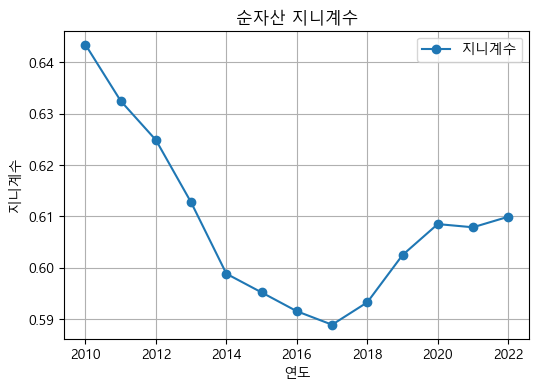

In [30]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니계수 열을 추출
years = gini_table['연도']
gini = gini_table['지니계수']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, gini, marker='o', linestyle='-', label='지니계수')
plt.title('순자산 지니계수')
plt.xlabel('연도')
plt.ylabel('지니계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 가구소득

In [31]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '비균등화', '균등화'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df 지정
    df_year = globals()[f'df_{year}']
    
    # 해당 연도의 '가구소득' 변수명 설정
    if year in range(2010, 2012):
        income = df_year['조사_경상소득']
    elif year in range(2012, 2017):
        income = df_year['경상소득(조사)']
    else:
        income = df_year['경상소득(보완)']
        
    # 단위: 100만 원
    x = income / 100
    
    # 가구원수 지정
    n = df_year['가구원수']
    
    # 가중치
    weight = df_year['가중값']
    weight_equiv = df_year['가중값']*n
    
    # 지니계수 계산
    non_equiv_gini = weighted_gini(x, weight)
    equiv_gini = weighted_gini(x/n**(0.5), weight_equiv)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '비균등화': [non_equiv_gini], 
                                          '균등화': [equiv_gini]})],
                           ignore_index=True)

# 결과를 출력
gini_table

,연도,비균등화,균등화
0,2010,0.432597,0.369490
1,2011,0.453477,0.391416
2,2012,0.437910,0.373645
3,2013,0.429451,0.366242
4,2014,0.425873,0.360785
5,2015,0.422841,0.356196
6,2016,0.421318,0.352948
7,2017,0.436399,0.368031
8,2018,0.437351,0.368955
9,2019,0.434313,0.362595


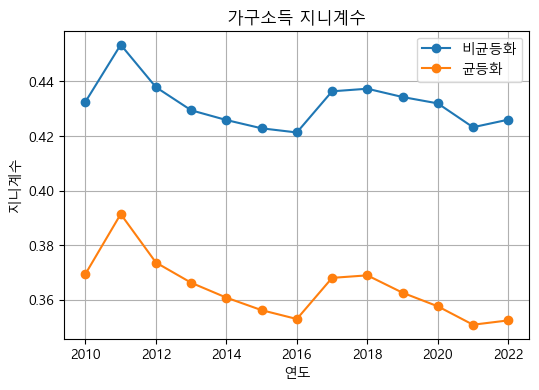

In [32]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니계수 열을 추출
years = gini_table['연도']
non_equiv_gini = gini_table['비균등화']
equiv_gini = gini_table['균등화']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, non_equiv_gini, marker='o', linestyle='-', label='비균등화')
plt.plot(years, equiv_gini, marker='o', linestyle='-', label='균등화')
plt.title('가구소득 지니계수')
plt.xlabel('연도')
plt.ylabel('지니계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()

### 처분가능소득

In [33]:
# 연도 범위 설정 (2010년부터 2022년까지)
years = range(2010, 2023)

# 결과를 저장할 데이터프레임 초기화
gini_table = pd.DataFrame(columns=['연도', '비균등화', '균등화'])

# 각 연도별로 반복
for year in years:
    # 해당 연도에 대한 df 지정
    df_year = globals()[f'df_{year}']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in range(2010, 2012):
        income = '조사_처분가능소득'
    elif year in range(2012, 2017):
        income = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'
        
    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in range(2010, 2012):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in range(2012, 2013):
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in range(2013, 2016):
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = df_year[income] + df_year[interest_payment]

    # 단위: 100만 원
    x = x / 100
    
    # 가구원수 지정
    n = df_year['가구원수']
    
    # 가중치
    weight = df_year['가중값']
    weight_equiv = df_year['가중값']*n
    
    # 지니계수 계산
    non_equiv_gini = weighted_gini(x, weight)
    equiv_gini = weighted_gini(x/n**(0.5), weight_equiv)
    
    # 결과를 데이터프레임에 추가
    gini_table = pd.concat([gini_table, 
                            pd.DataFrame({'연도': [year], 
                                          '비균등화': [non_equiv_gini], 
                                          '균등화': [equiv_gini]})],
                           ignore_index=True)

# 결과를 출력
gini_table

,연도,비균등화,균등화
0,2010,0.433686,0.371533
1,2011,0.453805,0.393312
2,2012,0.427650,0.363424
3,2013,0.422294,0.359348
4,2014,0.417371,0.352706
5,2015,0.413415,0.346935
6,2016,0.411177,0.343195
7,2017,0.425839,0.356554
8,2018,0.425811,0.356709
9,2019,0.419805,0.346225


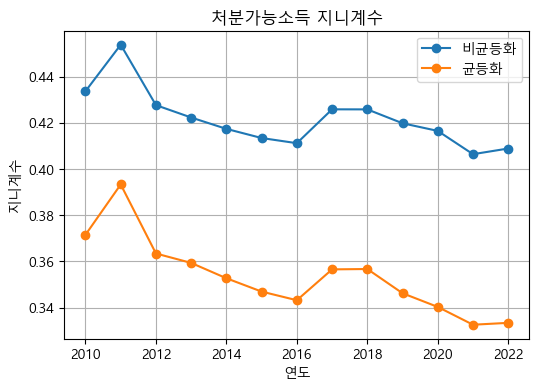

In [34]:
import matplotlib.pyplot as plt

# 데이터프레임에서 연도와 지니계수 열을 추출
years = gini_table['연도']
non_equiv_gini = gini_table['비균등화']
equiv_gini = gini_table['균등화']

# 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(years, non_equiv_gini, marker='o', linestyle='-', label='비균등화')
plt.plot(years, equiv_gini, marker='o', linestyle='-', label='균등화')
plt.title('처분가능소득 지니계수')
plt.xlabel('연도')
plt.ylabel('지니계수')
plt.grid(True)

# legend 추가
plt.legend()

# 그래프 표시
plt.show()